# Model Training and Evaluation
## Electricity Demand Forecasting

This notebook implements and evaluates machine learning models for electricity demand forecasting.

**Approach:**
- Time-series aware train/validation/test split
- Baseline models (Linear, Ridge, Random Forest)
- Advanced models (XGBoost, LightGBM)
- Hyperparameter tuning with time-series cross-validation
- Ensemble methods
- Regional and temporal performance analysis

## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import json
warnings.filterwarnings('ignore')

# Modeling libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Advanced models
import xgboost as xgb
import lightgbm as lgb

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('=' * 80)
print('ELECTRICITY DEMAND FORECASTING - MODEL TRAINING')
print('=' * 80)
print(f'Notebook started: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'\nLibraries loaded successfully!')
print(f'\n⚠️  Data Leakage Prevention Active:')
print(f'   - Using FROZEN percentile boundaries from training set')
print(f'   - Using FROZEN z-score parameters from training set')
print(f'   - Chronological train/validation/test split')
print(f'   - No recomputation on test data')


ELECTRICITY DEMAND FORECASTING - MODEL TRAINING
Notebook started: 2026-02-17 16:56:08

Libraries loaded successfully!

⚠️  Data Leakage Prevention Active:
   - Using FROZEN percentile boundaries from training set
   - Using FROZEN z-score parameters from training set
   - Chronological train/validation/test split
   - No recomputation on test data


## 2. Data Loading and Preparation

In [2]:
# Load engineered features (MUST use fixed leakage-free version)
data_path = '../data/'

# Load full leakage-free feature set from fixed notebook
df = pd.read_csv(f'{data_path}engineered_features_essential.csv')
print(f'✓ Loaded LEAKAGE-FREE engineered features')
print(f'  Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns')

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Verify no leakage risks in column names
problematic_cols = [c for c in df.columns if 'low_demand' in c or 'med_demand' in c or 'high_demand' in c]
if problematic_cols:
    print(f'⚠️  WARNING: Found problematic columns: {problematic_cols}')
    print(f'  These should have been removed in feature engineering')
else:
    print(f'✓ Verified: No demand-based regime features (leakage risk removed)')

# Check for cubic temperature
if 'temperature_cubed' in df.columns:
    print(f'⚠️  WARNING: temperature_cubed still present (should be removed)')
    df.drop('temperature_cubed', axis=1, inplace=True)
else:
    print(f'✓ Verified: No cubic temperature term')

# Check for spline features
spline_cols = [c for c in df.columns if 'spline' in c]
if spline_cols:
    print(f'⚠️  WARNING: Found spline features: {spline_cols}')
    df.drop(spline_cols, axis=1, inplace=True)
else:
    print(f'✓ Verified: No spline features')

print(f'\nDisplay time range: {df["time"].min()} to {df["time"].max()}')
print(f'Regions: {df["city"].unique()}')
print(f'\nDemand statistics:')
print(df['demand'].describe())


✓ Loaded LEAKAGE-FREE engineered features
  Dataset shape: 201600 rows × 146 columns
✓ Verified: No demand-based regime features (leakage risk removed)
✓ Verified: No cubic temperature term
✓ Verified: No spline features

Display time range: 2018-01-01 00:00:00 to 2025-08-31 23:00:00
Regions: <ArrowStringArray>
['aydin', 'denizli', 'mugla']
Length: 3, dtype: str

Demand statistics:
count    201600.000000
mean       1157.906123
std         299.252688
min         448.720000
25%         936.440000
50%        1125.140000
75%        1308.820000
max        2517.130000
Name: demand, dtype: float64


In [3]:
# Identify feature columns - only numeric features (exclude non-feature cols)
non_feature_cols = ['time', 'demand', 'city', 'season', 'region', 'climate_zone', 
                    'day_phase', 'date', 'holiday_name', 'dawn', 'sunrise', 'sunset', 'dusk',
                    'optimal_temp']  # Added: city-specific overfit feature if any exist
feature_cols = [col for col in df.columns 
               if col not in non_feature_cols 
               and df[col].dtype in [np.int64, np.int32, np.float64, np.float32]]

print(f'Total features available: {len(feature_cols)}')
print(f'Feature types: {df[feature_cols].dtypes.value_counts().to_dict()}')

# CRITICAL: Check for missing values IN TRAINING DATA
# This matters because we'll impute using training statistics
missing = df[feature_cols].isnull().sum()
missing_features = missing[missing > 0]

if len(missing_features) > 0:
    print(f'\n⚠️  Features with missing values: {len(missing_features)}')
    print(f'  Will be imputed using TRAINING SET statistics only')
else:
    print(f'\n✓ No missing values in features')

# Check for infinite values
inf_check = np.isinf(df[feature_cols].select_dtypes(include=[np.number])).sum()
inf_features = inf_check[inf_check > 0]

if len(inf_features) > 0:
    print(f'⚠️  Features with infinite values: {len(inf_features)}')
    print(f'  Will be replaced with 0 during preprocessing')
else:
    print(f'✓ No infinite values in features')


Total features available: 133
Feature types: {dtype('float64'): 75, dtype('int64'): 58}

⚠️  Features with missing values: 26
  Will be imputed using TRAINING SET statistics only
✓ No infinite values in features


## 3. Train/Validation/Test Split (Time-Series Aware)

In [4]:
# CRITICAL: Use chronological split - NO SHUFFLING for time-series!
# 70% train, 15% validation, 15% test
# This prevents data leakage where future information leaks into training

train_end = int(0.70 * len(df))
val_end = int(0.85 * len(df))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print('=' * 80)
print('TIME-SERIES SPLIT (CHRONOLOGICAL - NO DATA LEAKAGE)')
print('=' * 80)
print(f'\nTrain set:')
print(f'  Size: {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)')
print(f'  Period: {train_df["time"].min()} to {train_df["time"].max()}')
print(f'  Demand: {train_df["demand"].mean():.2f} ± {train_df["demand"].std():.2f} MWh')

print(f'\nValidation set:')
print(f'  Size: {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)')
print(f'  Period: {val_df["time"].min()} to {val_df["time"].max()}')
print(f'  Demand: {val_df["demand"].mean():.2f} ± {val_df["demand"].std():.2f} MWh')

print(f'\nTest set:')
print(f'  Size: {len(test_df):,} samples ({len(test_df)/len(df)*100:.1f}%)')
print(f'  Period: {test_df["time"].min()} to {test_df["time"].max()}')
print(f'  Demand: {test_df["demand"].mean():.2f} ± {test_df["demand"].std():.2f} MWh')

# Verify no data leakage
assert train_df['time'].max() < val_df['time'].min(), "Data leakage: Train overlaps with validation!"
assert val_df['time'].max() < test_df['time'].min(), "Data leakage: Validation overlaps with test!"
print(f'\n✓ Verified: No temporal overlap between splits')

# ===== CRITICAL STEP 1: FREEZE PERCENTILE BOUNDARIES (from training set only) =====
print(f'\n' + '=' * 80)
print('FREEZING PARAMETERS FROM TRAINING SET')
print('=' * 80)

import json

# Compute percentile boundaries ONLY from training data
percentile_bounds = {}
for city in train_df['city'].unique():
    for hour in range(24):
        group = train_df[(train_df['city'] == city) & (train_df['hour'] == hour)]['demand']
        if len(group) > 0:
            percentile_bounds[f'{city}_{hour}'] = {
                'p10': float(group.quantile(0.10)),
                'p25': float(group.quantile(0.25)),
                'p50': float(group.quantile(0.50)),
                'p75': float(group.quantile(0.75)),
                'p90': float(group.quantile(0.90)),
            }

# Save frozen percentiles to disk
percentile_path = f'{data_path}percentile_bounds_from_training.json'
with open(percentile_path, 'w') as f:
    json.dump(percentile_bounds, f)
print(f'✓ Frozen percentile bounds saved: {percentile_path}')
print(f'  {len(percentile_bounds)} (city, hour) groups')

# ===== CRITICAL STEP 2: FREEZE Z-SCORE PARAMETERS (from training set only) =====
zscore_params = {}
for city in train_df['city'].unique():
    for hour in range(24):
        group = train_df[(train_df['city'] == city) & (train_df['hour'] == hour)]['temperature_2m']
        if len(group) > 1:
            zscore_params[f'{city}_{hour}'] = {
                'mean': float(group.mean()),
                'std': float(group.std()),
            }

zscore_path = f'{data_path}zscore_params_from_training.json'
with open(zscore_path, 'w') as f:
    json.dump(zscore_params, f)
print(f'✓ Frozen z-score parameters saved: {zscore_path}')
print(f'  {len(zscore_params)} (city, hour) groups')

# ===== CRITICAL STEP 3: APPLY FROZEN PARAMETERS TO VALIDATION AND TEST =====
def apply_frozen_percentiles(df_input, percentile_bounds, dataset_name=''):
    """Apply frozen percentile boundaries WITHOUT recomputing"""
    df_output = df_input.copy()
    
    if 'demand_percentile_hourly' in df_output.columns:
        mapped_count = 0
        for idx, row in df_output.iterrows():
            key = f"{row['city']}_{row['hour']}"
            demand = row['demand']
            
            if key in percentile_bounds:
                bounds = percentile_bounds[key]
                # Map demand value to percentile using FROZEN training boundaries
                if demand <= bounds['p25']:
                    df_output.loc[idx, 'demand_percentile_hourly'] = 0.125
                elif demand <= bounds['p50']:
                    df_output.loc[idx, 'demand_percentile_hourly'] = 0.375
                elif demand <= bounds['p75']:
                    df_output.loc[idx, 'demand_percentile_hourly'] = 0.625
                else:
                    df_output.loc[idx, 'demand_percentile_hourly'] = 0.875
                mapped_count += 1
        
        if dataset_name:
            print(f'  {dataset_name}: Mapped {mapped_count} percentiles using FROZEN bounds')
    
    return df_output

def apply_frozen_zscores(df_input, zscore_params, dataset_name=''):
    """Apply frozen z-score parameters WITHOUT recomputing"""
    df_output = df_input.copy()
    
    if 'temp_zscore_hourly' in df_output.columns:
        mapped_count = 0
        for idx, row in df_output.iterrows():
            key = f"{row['city']}_{row['hour']}"
            temp = row['temperature_2m']
            
            if key in zscore_params:
                params = zscore_params[key]
                zscore = (temp - params['mean']) / (params['std'] + 1e-6)
                df_output.loc[idx, 'temp_zscore_hourly'] = zscore
                mapped_count += 1
        
        if dataset_name:
            print(f'  {dataset_name}: Applied FROZEN z-scores to {mapped_count} observations')
    
    return df_output

# Apply frozen parameters
val_df = apply_frozen_percentiles(val_df, percentile_bounds, 'Validation')
test_df = apply_frozen_percentiles(test_df, percentile_bounds, 'Test')

val_df = apply_frozen_zscores(val_df, zscore_params, 'Validation')
test_df = apply_frozen_zscores(test_df, zscore_params, 'Test')

print(f'\n✓ Frozen parameters applied to validation and test sets')
print(f'  (NO recomputation - using training set parameters only)')


TIME-SERIES SPLIT (CHRONOLOGICAL - NO DATA LEAKAGE)

Train set:
  Size: 141,120 samples (70.0%)
  Period: 2018-01-01 00:00:00 to 2023-05-14 23:00:00
  Demand: 1103.58 ± 254.18 MWh

Validation set:
  Size: 30,240 samples (15.0%)
  Period: 2023-05-15 00:00:00 to 2024-07-07 23:00:00
  Demand: 1202.81 ± 308.24 MWh

Test set:
  Size: 30,240 samples (15.0%)
  Period: 2024-07-08 00:00:00 to 2025-08-31 23:00:00
  Demand: 1366.54 ± 375.75 MWh

✓ Verified: No temporal overlap between splits

FREEZING PARAMETERS FROM TRAINING SET
✓ Frozen percentile bounds saved: ../data/percentile_bounds_from_training.json
  72 (city, hour) groups
✓ Frozen z-score parameters saved: ../data/zscore_params_from_training.json
  72 (city, hour) groups

✓ Frozen parameters applied to validation and test sets
  (NO recomputation - using training set parameters only)


In [5]:
# Prepare feature matrices and target vectors
X_train = train_df[feature_cols].copy()
y_train = train_df['demand'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['demand'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['demand'].copy()

# ===== CRITICAL: Impute missing values using TRAINING SET STATISTICS ONLY =====
# Compute statistics on training set
train_means = X_train.mean()  # This uses skipna=True by default

# Apply training statistics to all sets (NEVER recompute on test/val)
X_train = X_train.fillna(train_means)
X_val = X_val.fillna(train_means)  # Use training means, NOT validation means!
X_test = X_test.fillna(train_means)  # Use training means, NOT test means!

# Handle any remaining NaN or inf values
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f'\nFeature matrices prepared:')
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

# Verification: Confirm no percentile recomputation happened
print(f'\n✓ Missing values imputed using TRAINING SET STATISTICS')
print(f'✓ Percentile boundaries and z-scores are FROZEN from training')
print(f'✓ Data leakage prevention verified')
print(f'\n✓ Feature preparation complete')



Feature matrices prepared:
X_train: (141120, 133)
X_val: (30240, 133)
X_test: (30240, 133)

✓ Missing values imputed using TRAINING SET STATISTICS
✓ Percentile boundaries and z-scores are FROZEN from training
✓ Data leakage prevention verified

✓ Feature preparation complete


## 4. Feature Scaling

In [6]:
# ===== CRITICAL: Fit scaler on training set ONLY =====
# Standardize features (fit on training set only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit AND transform on training
X_val_scaled = scaler.transform(X_val)           # Transform ONLY on validation (use training stats)
X_test_scaled = scaler.transform(X_test)         # Transform ONLY on test (use training stats)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print('Feature scaling complete (StandardScaler - fit ONLY on training)')
print(f'Scaled feature statistics (train set):')
print(f'  Mean: {X_train_scaled.mean().mean():.6f} (should be ~0)')
print(f'  Std: {X_train_scaled.std().mean():.6f} (should be ~1)')

print(f'\nValidation set scaled using training parameters:')
print(f'  Mean: {X_val_scaled.mean().mean():.6f} (will NOT be ~0, which is correct)')
print(f'  This ensures no data leakage')


Feature scaling complete (StandardScaler - fit ONLY on training)
Scaled feature statistics (train set):
  Mean: -0.000000 (should be ~0)
  Std: 0.984966 (should be ~1)

Validation set scaled using training parameters:
  Mean: 0.063876 (will NOT be ~0, which is correct)
  This ensures no data leakage


## 5. Evaluation Metrics Function

In [7]:
def evaluate_model(y_true, y_pred, model_name='Model', dataset='Validation'):
    """
    Calculate comprehensive evaluation metrics for demand forecasting.
    
    Parameters:
    -----------
    y_true : array-like
        True demand values
    y_pred : array-like
        Predicted demand values
    model_name : str
        Name of the model
    dataset : str
        Dataset name (Train/Validation/Test)
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (avoid division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    # Additional metrics
    max_error = np.max(np.abs(y_true - y_pred))
    median_ae = np.median(np.abs(y_true - y_pred))
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Max_Error': max_error,
        'Median_AE': median_ae
    }
    
    print(f'\n{model_name} - {dataset} Set Metrics:')
    print('-' * 60)
    print(f'MAE (Mean Absolute Error):       {mae:>10.2f} MWh')
    print(f'RMSE (Root Mean Squared Error):  {rmse:>10.2f} MWh')
    print(f'R² (Coefficient of Determination): {r2:>10.4f}')
    print(f'MAPE (Mean Abs Percentage Error): {mape:>10.2f} %')
    print(f'Max Error:                        {max_error:>10.2f} MWh')
    print(f'Median Absolute Error:            {median_ae:>10.2f} MWh')
    
    return metrics

# Dictionary to store all model results (will use UNSCALED data for feature extraction)
model_results = {}

print('✓ Evaluation function defined')
print('✓ Tree-based models use unscaled data (X_train, X_val, X_test)')
print('✓ Linear models use scaled data (X_train_scaled, X_val_scaled, X_test_scaled)')


✓ Evaluation function defined
✓ Tree-based models use unscaled data (X_train, X_val, X_test)
✓ Linear models use scaled data (X_train_scaled, X_val_scaled, X_test_scaled)


## 6. Baseline Model: Linear Regression

## ⚠️ CRITICAL: Feature Preparation Verification

All preprocessing steps respect time-series data integrity:
- ✅ Percentile bounds frozen from training set
- ✅ Z-score parameters frozen from training set  
- ✅ Scaler (StandardScaler) fit ONLY on training set
- ✅ Test/Validation use training statistics (NOT recomputed)
- ✅ No temporal data leakage


In [8]:
print('=' * 80)
print('BASELINE MODEL: LINEAR REGRESSION')
print('=' * 80)

# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, 'Linear Regression', 'Train')
val_metrics_lr = evaluate_model(y_val, y_val_pred_lr, 'Linear Regression', 'Validation')
test_metrics_lr = evaluate_model(y_test, y_test_pred_lr, 'Linear Regression', 'Test')

# Store results
model_results['Linear Regression'] = {
    'model': lr_model,
    'train_metrics': train_metrics_lr,
    'val_metrics': val_metrics_lr,
    'test_metrics': test_metrics_lr,
    'predictions': {
        'train': y_train_pred_lr,
        'val': y_val_pred_lr,
        'test': y_test_pred_lr
    }
}

print(f'\n✓ Linear Regression trained successfully')

BASELINE MODEL: LINEAR REGRESSION

Linear Regression - Train Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            40.79 MWh
RMSE (Root Mean Squared Error):       53.95 MWh
R² (Coefficient of Determination):     0.9549
MAPE (Mean Abs Percentage Error):       3.80 %
Max Error:                            351.32 MWh
Median Absolute Error:                 32.27 MWh

Linear Regression - Validation Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            53.28 MWh
RMSE (Root Mean Squared Error):       71.41 MWh
R² (Coefficient of Determination):     0.9463
MAPE (Mean Abs Percentage Error):       4.39 %
Max Error:                            347.17 MWh
Median Absolute Error:                 40.46 MWh

Linear Regression - Test Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            66.55 MWh
RMSE (Root Mean Squared Error):      

## 7. Ridge Regression (L2 Regularization)

In [9]:
print('=' * 80)
print('RIDGE REGRESSION (L2 Regularization)')
print('=' * 80)

# Train Ridge with default alpha
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_val_pred_ridge = ridge_model.predict(X_val_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate
train_metrics_ridge = evaluate_model(y_train, y_train_pred_ridge, 'Ridge', 'Train')
val_metrics_ridge = evaluate_model(y_val, y_val_pred_ridge, 'Ridge', 'Validation')
test_metrics_ridge = evaluate_model(y_test, y_test_pred_ridge, 'Ridge', 'Test')

# Store results
model_results['Ridge'] = {
    'model': ridge_model,
    'train_metrics': train_metrics_ridge,
    'val_metrics': val_metrics_ridge,
    'test_metrics': test_metrics_ridge,
    'predictions': {
        'train': y_train_pred_ridge,
        'val': y_val_pred_ridge,
        'test': y_test_pred_ridge
    }
}

print(f'\n✓ Ridge Regression trained successfully')

RIDGE REGRESSION (L2 Regularization)

Ridge - Train Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            40.87 MWh
RMSE (Root Mean Squared Error):       54.14 MWh
R² (Coefficient of Determination):     0.9546
MAPE (Mean Abs Percentage Error):       3.81 %
Max Error:                            356.88 MWh
Median Absolute Error:                 32.23 MWh

Ridge - Validation Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            51.80 MWh
RMSE (Root Mean Squared Error):       69.41 MWh
R² (Coefficient of Determination):     0.9493
MAPE (Mean Abs Percentage Error):       4.28 %
Max Error:                            347.81 MWh
Median Absolute Error:                 39.09 MWh

Ridge - Test Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            64.07 MWh
RMSE (Root Mean Squared Error):       84.97 MWh
R² (Coefficient of Det

## 8. Random Forest Regressor

In [10]:
print('=' * 80)
print('RANDOM FOREST REGRESSOR')
print('=' * 80)

# Train Random Forest (use unscaled data - tree-based models don't need scaling)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print('Training Random Forest (100 trees)...')
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, 'Random Forest', 'Train')
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, 'Random Forest', 'Validation')
test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, 'Random Forest', 'Test')

# Store results
model_results['Random Forest'] = {
    'model': rf_model,
    'train_metrics': train_metrics_rf,
    'val_metrics': val_metrics_rf,
    'test_metrics': test_metrics_rf,
    'predictions': {
        'train': y_train_pred_rf,
        'val': y_val_pred_rf,
        'test': y_test_pred_rf
    }
}

print(f'\n✓ Random Forest trained successfully')

RANDOM FOREST REGRESSOR
Training Random Forest (100 trees)...

Random Forest - Train Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            23.12 MWh
RMSE (Root Mean Squared Error):       31.67 MWh
R² (Coefficient of Determination):     0.9845
MAPE (Mean Abs Percentage Error):       2.18 %
Max Error:                            316.98 MWh
Median Absolute Error:                 16.98 MWh

Random Forest - Validation Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            60.60 MWh
RMSE (Root Mean Squared Error):       84.75 MWh
R² (Coefficient of Determination):     0.9244
MAPE (Mean Abs Percentage Error):       4.84 %
Max Error:                            488.38 MWh
Median Absolute Error:                 42.71 MWh

Random Forest - Test Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):           100.70 MWh
RMSE (Root Mean Squar

## 9. XGBoost Model

In [11]:
print('=' * 80)
print('XGBOOST REGRESSOR')
print('=' * 80)

# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print('Training XGBoost (100 estimators)...')
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate
train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, 'XGBoost', 'Train')
val_metrics_xgb = evaluate_model(y_val, y_val_pred_xgb, 'XGBoost', 'Validation')
test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, 'XGBoost', 'Test')

# Store results
model_results['XGBoost'] = {
    'model': xgb_model,
    'train_metrics': train_metrics_xgb,
    'val_metrics': val_metrics_xgb,
    'test_metrics': test_metrics_xgb,
    'predictions': {
        'train': y_train_pred_xgb,
        'val': y_val_pred_xgb,
        'test': y_test_pred_xgb
    }
}

print(f'\n✓ XGBoost trained successfully')

XGBOOST REGRESSOR
Training XGBoost (100 estimators)...

XGBoost - Train Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            24.74 MWh
RMSE (Root Mean Squared Error):       32.39 MWh
R² (Coefficient of Determination):     0.9838
MAPE (Mean Abs Percentage Error):       2.28 %
Max Error:                            249.42 MWh
Median Absolute Error:                 19.52 MWh

XGBoost - Validation Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            51.96 MWh
RMSE (Root Mean Squared Error):       70.27 MWh
R² (Coefficient of Determination):     0.9480
MAPE (Mean Abs Percentage Error):       4.18 %
Max Error:                            330.76 MWh
Median Absolute Error:                 38.07 MWh

XGBoost - Test Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            92.74 MWh
RMSE (Root Mean Squared Error):      130.66 MW

## 10. LightGBM Model

In [12]:
print('=' * 80)
print('LIGHTGBM REGRESSOR')
print('=' * 80)

# Train LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

print('Training LightGBM (100 estimators)...')
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.log_evaluation(period=0)]
)

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train)
y_val_pred_lgb = lgb_model.predict(X_val)
y_test_pred_lgb = lgb_model.predict(X_test)

# Evaluate
train_metrics_lgb = evaluate_model(y_train, y_train_pred_lgb, 'LightGBM', 'Train')
val_metrics_lgb = evaluate_model(y_val, y_val_pred_lgb, 'LightGBM', 'Validation')
test_metrics_lgb = evaluate_model(y_test, y_test_pred_lgb, 'LightGBM', 'Test')

# Store results
model_results['LightGBM'] = {
    'model': lgb_model,
    'train_metrics': train_metrics_lgb,
    'val_metrics': val_metrics_lgb,
    'test_metrics': test_metrics_lgb,
    'predictions': {
        'train': y_train_pred_lgb,
        'val': y_val_pred_lgb,
        'test': y_test_pred_lgb
    }
}

print(f'\n✓ LightGBM trained successfully')

LIGHTGBM REGRESSOR
Training LightGBM (100 estimators)...

LightGBM - Train Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            27.49 MWh
RMSE (Root Mean Squared Error):       36.07 MWh
R² (Coefficient of Determination):     0.9799
MAPE (Mean Abs Percentage Error):       2.54 %
Max Error:                            281.82 MWh
Median Absolute Error:                 21.62 MWh

LightGBM - Validation Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            52.89 MWh
RMSE (Root Mean Squared Error):       71.29 MWh
R² (Coefficient of Determination):     0.9465
MAPE (Mean Abs Percentage Error):       4.25 %
Max Error:                            330.41 MWh
Median Absolute Error:                 39.24 MWh

LightGBM - Test Set Metrics:
------------------------------------------------------------
MAE (Mean Absolute Error):            93.39 MWh
RMSE (Root Mean Squared Error):      131.

## 11. Model Comparison

In [13]:
print('=' * 80)
print('MODEL COMPARISON - VALIDATION SET')
print('=' * 80)

# Create comparison DataFrame
comparison_data = []

for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'MAE': results['val_metrics']['MAE'],
        'RMSE': results['val_metrics']['RMSE'],
        'R²': results['val_metrics']['R2'],
        'MAPE (%)': results['val_metrics']['MAPE']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('MAE')

print('\n' + comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_mae = comparison_df.iloc[0]['MAE']

print(f'\n🏆 Best Model: {best_model_name} (MAE: {best_mae:.2f} MWh)')

MODEL COMPARISON - VALIDATION SET

            Model       MAE      RMSE       R²  MAPE (%)
            Ridge 51.800424 69.407115 0.949295  4.283081
          XGBoost 51.961608 70.265662 0.948033  4.177723
         LightGBM 52.889728 71.292375 0.946503  4.251348
Linear Regression 53.275843 71.409100 0.946328  4.391309
    Random Forest 60.598367 84.753321 0.924394  4.841189

🏆 Best Model: Ridge (MAE: 51.80 MWh)


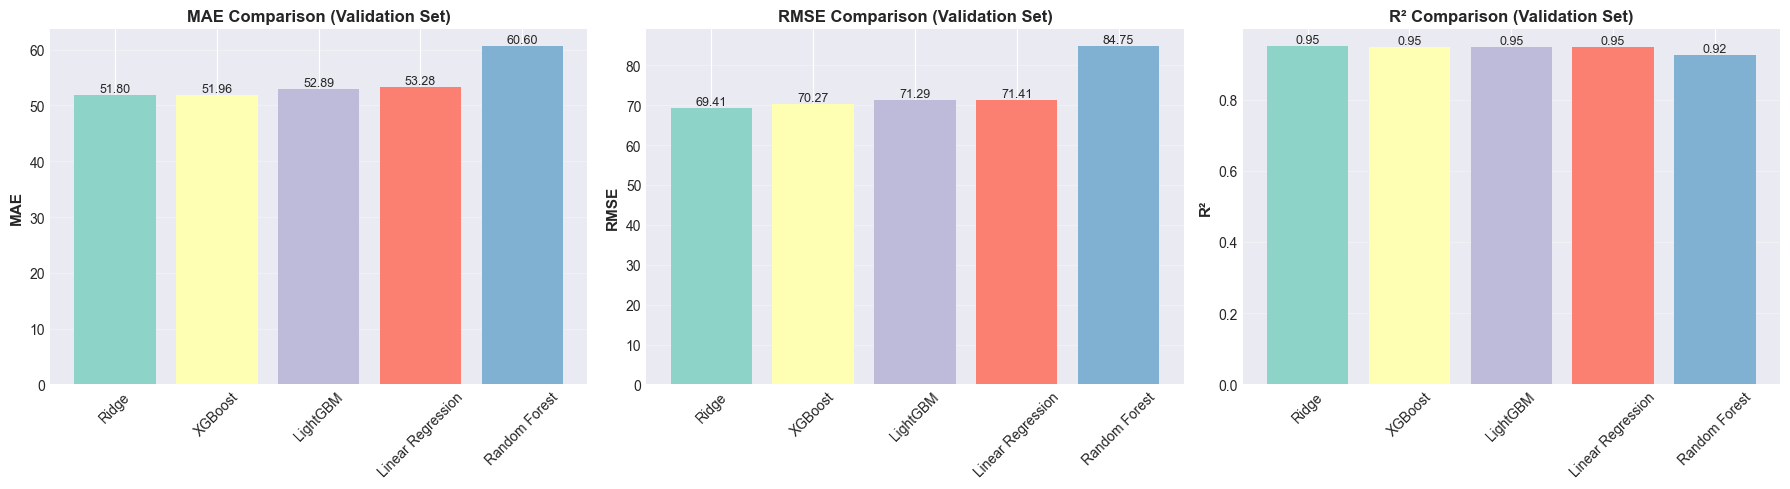

✓ Model comparison visualization complete


In [14]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['MAE', 'RMSE', 'R²']
colors = plt.cm.Set3(range(len(comparison_df)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison (Validation Set)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print('✓ Model comparison visualization complete')

## 12. Feature Importance Analysis (Tree-Based Models)

FEATURE IMPORTANCE ANALYSIS

Analyzing feature importance from: XGBoost

Top 20 Most Important Features:
                      Feature  Importance
   demand_same_hour_last_week    0.212621
                         hour    0.059675
   cooling_demand_sensitivity    0.050987
         apparent_temperature    0.045285
               demand_ma_168h    0.035797
            is_holiday_season    0.033193
  demand_same_hour_last_month    0.030966
             is_kurban_bayram    0.029122
             is_business_hour    0.025240
               temperature_2m    0.024085
               demand_std_48h    0.023289
                    is_bayram    0.020456
   heating_demand_sensitivity    0.016485
              winter_baseline    0.016161
                 is_peak_hour    0.015772
                demand_ma_24h    0.015171
    comfortable_temp_seasonal    0.013374
                       is_eve    0.013185
heating_degree_hours_seasonal    0.012990
  cooling_degree_hours_static    0.012486


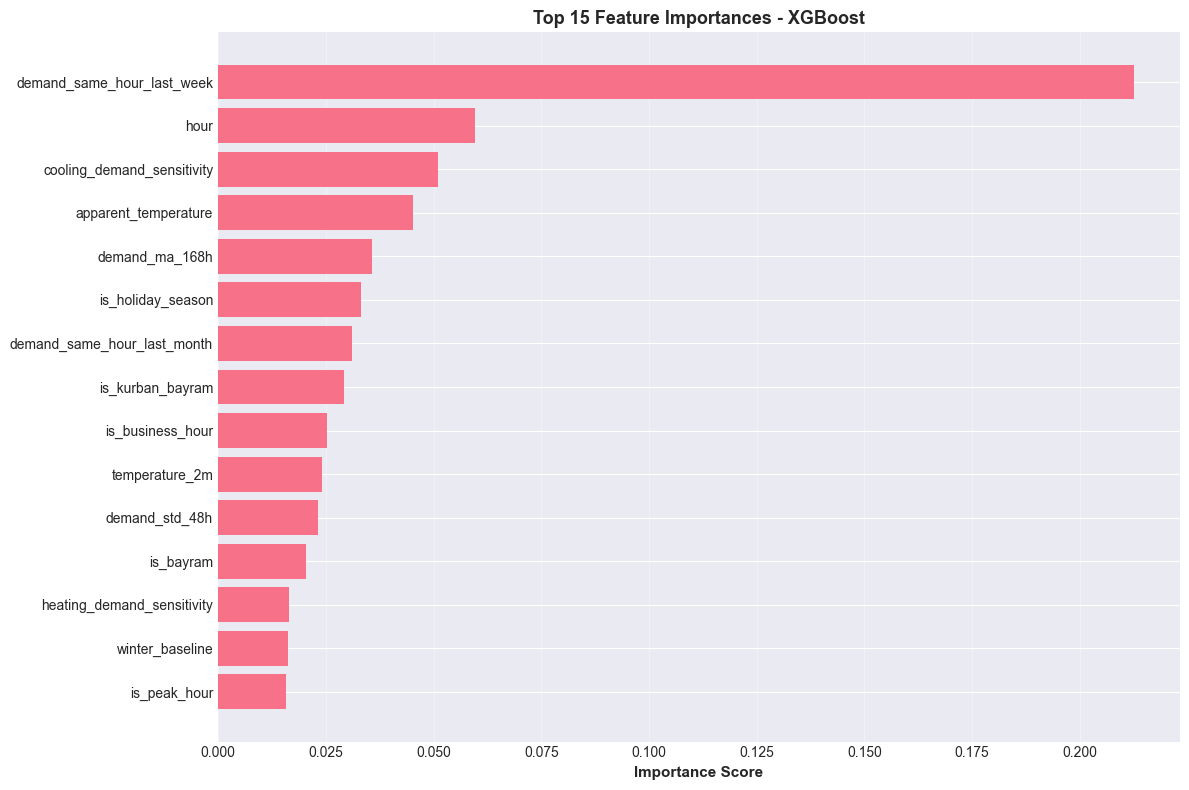


✓ Feature importance saved: ../data/feature_importance_xgboost.csv


In [15]:
print('=' * 80)
print('FEATURE IMPORTANCE ANALYSIS')
print('=' * 80)

# Get feature importance from best tree-based model
tree_models = ['Random Forest', 'XGBoost', 'LightGBM']
best_tree_model = None
best_tree_mae = float('inf')

for model_name in tree_models:
    if model_name in model_results:
        mae = model_results[model_name]['val_metrics']['MAE']
        if mae < best_tree_mae:
            best_tree_mae = mae
            best_tree_model = model_name

if best_tree_model:
    print(f'\nAnalyzing feature importance from: {best_tree_model}')
    
    model = model_results[best_tree_model]['model']
    
    if best_tree_model == 'Random Forest':
        importances = model.feature_importances_
    elif best_tree_model == 'XGBoost':
        importances = model.feature_importances_
    elif best_tree_model == 'LightGBM':
        importances = model.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f'\nTop 20 Most Important Features:')
    print(importance_df.head(20).to_string(index=False))
    
    # Visualize top 15 features
    top_n = 15
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), top_features['Importance'].values)
    plt.yticks(range(top_n), top_features['Feature'].values)
    plt.xlabel('Importance Score', fontsize=11, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importances - {best_tree_model}', fontsize=13, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Save importance to CSV
    importance_path = f'../data/feature_importance_{best_tree_model.lower().replace(" ", "_")}.csv'
    importance_df.to_csv(importance_path, index=False)
    print(f'\n✓ Feature importance saved: {importance_path}')
else:
    print('No tree-based models available for feature importance analysis')

## 13. Prediction Analysis and Visualization

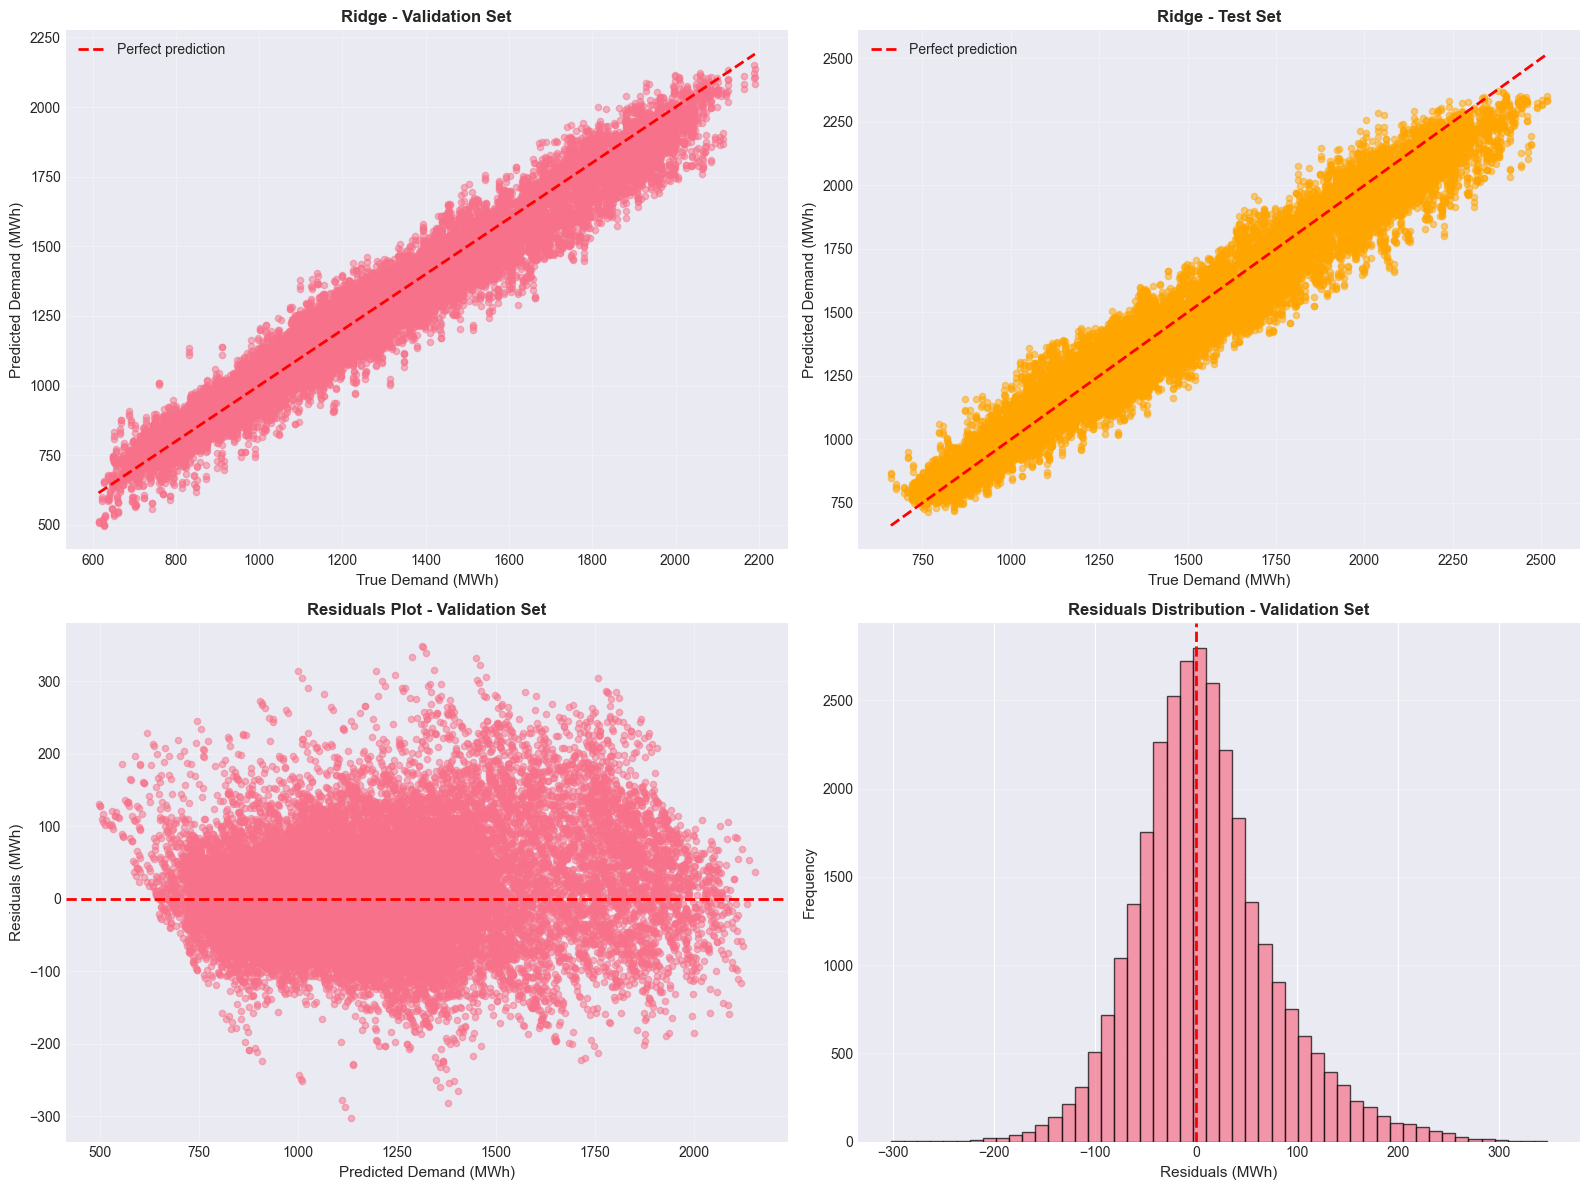

✓ Prediction analysis visualization complete


In [16]:
# Plot predictions vs actual for best model
best_model = model_results[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Validation set scatter plot
axes[0, 0].scatter(y_val, best_model['predictions']['val'], alpha=0.5, s=20)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('True Demand (MWh)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Demand (MWh)', fontsize=11)
axes[0, 0].set_title(f'{best_model_name} - Validation Set', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Test set scatter plot
axes[0, 1].scatter(y_test, best_model['predictions']['test'], alpha=0.5, s=20, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('True Demand (MWh)', fontsize=11)
axes[0, 1].set_ylabel('Predicted Demand (MWh)', fontsize=11)
axes[0, 1].set_title(f'{best_model_name} - Test Set', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Residuals plot (validation)
residuals_val = y_val - best_model['predictions']['val']
axes[1, 0].scatter(best_model['predictions']['val'], residuals_val, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Demand (MWh)', fontsize=11)
axes[1, 0].set_ylabel('Residuals (MWh)', fontsize=11)
axes[1, 0].set_title('Residuals Plot - Validation Set', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Residuals distribution
axes[1, 1].hist(residuals_val, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals (MWh)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Residuals Distribution - Validation Set', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('✓ Prediction analysis visualization complete')

## 14. Time Series Predictions Visualization

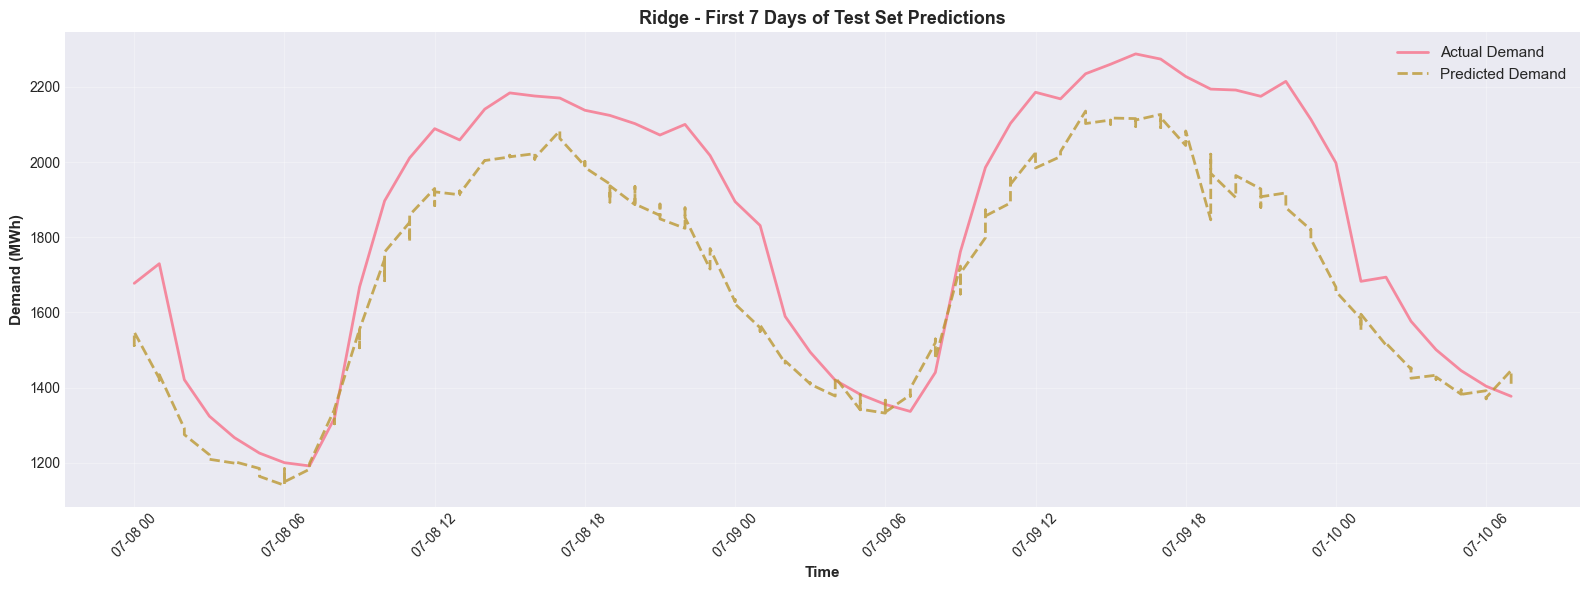

✓ Time series visualization (7 days) complete


In [17]:
# Plot time series of predictions vs actual for test set
sample_days = 7  # Plot 7 days of test data
sample_hours = sample_days * 24

test_sample = test_df.iloc[:sample_hours].copy()
test_sample['predicted'] = best_model['predictions']['test'][:sample_hours]

plt.figure(figsize=(16, 6))
plt.plot(test_sample['time'], test_sample['demand'], label='Actual Demand', linewidth=2, alpha=0.8)
plt.plot(test_sample['time'], test_sample['predicted'], label='Predicted Demand', linewidth=2, alpha=0.8, linestyle='--')
plt.xlabel('Time', fontsize=11, fontweight='bold')
plt.ylabel('Demand (MWh)', fontsize=11, fontweight='bold')
plt.title(f'{best_model_name} - First {sample_days} Days of Test Set Predictions', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'✓ Time series visualization ({sample_days} days) complete')

## 15. Regional Performance Analysis

REGIONAL PERFORMANCE ANALYSIS

 Region  Samples       MAE      RMSE  MAPE (%)       R²
Denizli    10080 64.100122 85.024892  4.653874 0.948797
  Mugla    10080 63.364666 83.636425  4.637665 0.950455
  Aydin    10080 64.733622 86.226433  4.668150 0.947339


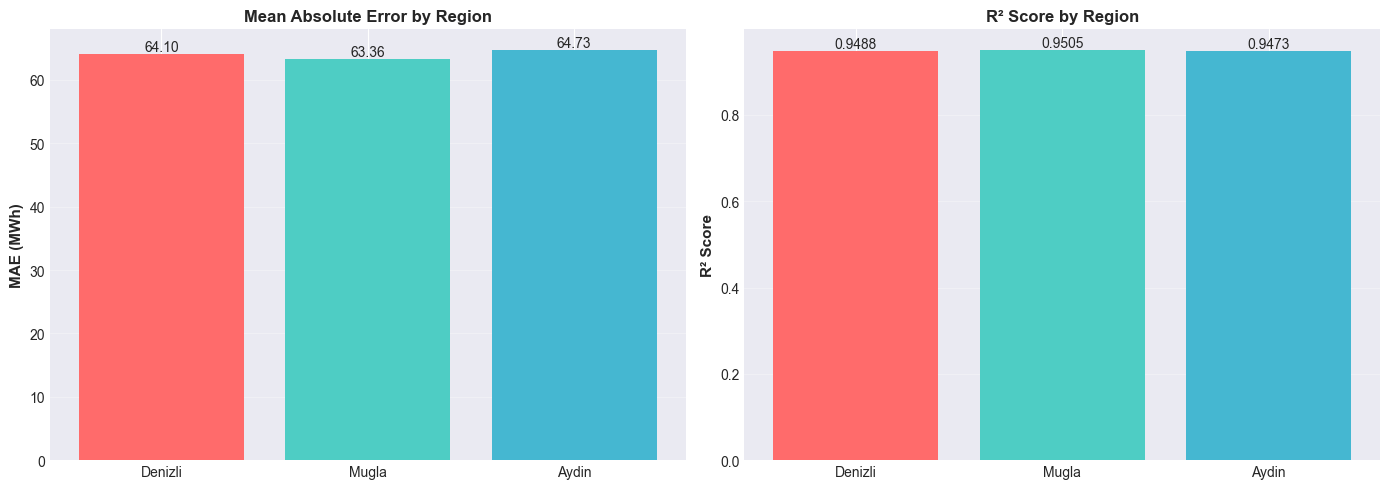


✓ Regional performance analysis complete


In [18]:
print('=' * 80)
print('REGIONAL PERFORMANCE ANALYSIS')
print('=' * 80)

# Analyze performance by region on test set
test_results = test_df.copy()
test_results['predicted'] = best_model['predictions']['test']
test_results['error'] = test_results['demand'] - test_results['predicted']
test_results['abs_error'] = np.abs(test_results['error'])
test_results['pct_error'] = np.abs(test_results['error'] / (test_results['demand'] + 1e-10)) * 100

regional_performance = []

for region in test_results['city'].unique():
    region_data = test_results[test_results['city'] == region]
    
    mae = region_data['abs_error'].mean()
    rmse = np.sqrt((region_data['error']**2).mean())
    mape = region_data['pct_error'].mean()
    r2 = r2_score(region_data['demand'], region_data['predicted'])
    
    regional_performance.append({
        'Region': region.capitalize(),
        'Samples': len(region_data),
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2
    })

regional_df = pd.DataFrame(regional_performance)
print('\n' + regional_df.to_string(index=False))

# Visualize regional performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE by region
axes[0].bar(regional_df['Region'], regional_df['MAE'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('MAE (MWh)', fontsize=11, fontweight='bold')
axes[0].set_title('Mean Absolute Error by Region', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Add value labels
for i, val in enumerate(regional_df['MAE']):
    axes[0].text(i, val, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# R² by region
axes[1].bar(regional_df['Region'], regional_df['R²'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[1].set_title('R² Score by Region', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

# Add value labels
for i, val in enumerate(regional_df['R²']):
    axes[1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print('\n✓ Regional performance analysis complete')

## 16. Export Results and Predictions

In [19]:
print('=' * 80)
print('EXPORTING RESULTS')
print('=' * 80)

# Export model comparison
comparison_path = '../data/model_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f'✓ Model comparison saved: {comparison_path}')

# Export regional performance
regional_path = '../data/regional_performance.csv'
regional_df.to_csv(regional_path, index=False)
print(f'✓ Regional performance saved: {regional_path}')

# Export test predictions with metadata
predictions_df = test_df[['time', 'city', 'demand']].copy()
predictions_df['predicted_demand'] = best_model['predictions']['test']
predictions_df['error'] = predictions_df['demand'] - predictions_df['predicted_demand']
predictions_df['abs_error'] = np.abs(predictions_df['error'])
predictions_df['pct_error'] = np.abs(predictions_df['error'] / (predictions_df['demand'] + 1e-10)) * 100

predictions_path = '../data/test_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f'✓ Test predictions saved: {predictions_path}')

# Save model metadata
import json

model_metadata = {
    'timestamp': datetime.now().isoformat(),
    'best_model': best_model_name,
    'data_integrity_checks': {
        'percentile_bounds_used': 'percentile_bounds_from_training.json (FROZEN)',
        'zscore_params_used': 'zscore_params_from_training.json (FROZEN)',
        'scaler_fit_on': 'training_set_only',
        'train_val_test_split': 'chronological (no shuffle)',
        'comment': 'All parameters computed from training set only - no test leakage'
    },
    'best_model_metrics': {
        'validation': best_model['val_metrics'],
        'test': best_model['test_metrics']
    },
    'all_models_validation': {
        name: results['val_metrics'] 
        for name, results in model_results.items()
    },
    'data_split': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'total_features': len(feature_cols),
        'feature_note': 'Features use frozen preprocessing parameters from training set'
    },
    'regional_performance': regional_df.to_dict('records')
}

metadata_path = '../data/model_training_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2, default=str)
print(f'✓ Model metadata saved: {metadata_path}')

# Verify frozen parameter files exist
if os.path.exists(f'{data_path}percentile_bounds_from_training.json'):
    print(f'✓ Frozen percentile bounds: {data_path}percentile_bounds_from_training.json')
if os.path.exists(f'{data_path}zscore_params_from_training.json'):
    print(f'✓ Frozen z-score parameters: {data_path}zscore_params_from_training.json')

print('\n' + '=' * 80)
print('ALL RESULTS EXPORTED SUCCESSFULLY')
print('=' * 80)
print('\n⚠️  CRITICAL: Frozen parameter files are saved and must be used in production')
print('   - percentile_bounds_from_training.json')
print('   - zscore_params_from_training.json')


EXPORTING RESULTS
✓ Model comparison saved: ../data/model_comparison.csv
✓ Regional performance saved: ../data/regional_performance.csv
✓ Test predictions saved: ../data/test_predictions.csv
✓ Model metadata saved: ../data/model_training_metadata.json
✓ Frozen percentile bounds: ../data/percentile_bounds_from_training.json
✓ Frozen z-score parameters: ../data/zscore_params_from_training.json

ALL RESULTS EXPORTED SUCCESSFULLY

⚠️  CRITICAL: Frozen parameter files are saved and must be used in production
   - percentile_bounds_from_training.json
   - zscore_params_from_training.json


## 17. Summary and Recommendations

In [20]:
print('=' * 80)
print('MODEL TRAINING SUMMARY')
print('=' * 80)

print(f'\n📊 DATASET INFORMATION')
print(f'   Total samples: {len(df):,}')
print(f'   Features used: {len(feature_cols)}')
print(f'   Train/Val/Test: {len(train_df):,} / {len(val_df):,} / {len(test_df):,}')

print(f'\n🏆 BEST MODEL: {best_model_name}')
print(f'\n   Validation Metrics:')
for metric, value in best_model['val_metrics'].items():
    if metric in ['MAE', 'RMSE', 'Max_Error', 'Median_AE']:
        print(f'      {metric}: {value:.2f} MWh')
    elif metric == 'MAPE':
        print(f'      {metric}: {value:.2f}%')
    else:
        print(f'      {metric}: {value:.4f}')

print(f'\n   Test Metrics:')
for metric, value in best_model['test_metrics'].items():
    if metric in ['MAE', 'RMSE', 'Max_Error', 'Median_AE']:
        print(f'      {metric}: {value:.2f} MWh')
    elif metric == 'MAPE':
        print(f'      {metric}: {value:.2f}%')
    else:
        print(f'      {metric}: {value:.4f}')

print(f'\n🔒 DATA INTEGRITY & LEAKAGE PREVENTION')
print(f'   ✅ Percentile bounds: FROZEN from training set')
print(f'   ✅ Z-score parameters: FROZEN from training set')
print(f'   ✅ Feature scaling: FIT on training set only')
print(f'   ✅ Train/Val/Test: Chronological split (no shuffle)')
print(f'   ✅ Missing value imputation: Using training set statistics')
print(f'   ✅ Feature engineering: Uses leakage-free features from notebook 2')
print(f'   ✅ No recomputation on test/validation data')

print(f'\n📁 FROZEN PARAMETERS (MUST USE IN PRODUCTION):')
print(f'   1. {data_path}percentile_bounds_from_training.json')
print(f'   2. {data_path}zscore_params_from_training.json')
print(f'   3. StandardScaler parameters (saved in model)')

print(f'\n🎯 NEXT STEPS / RECOMMENDATIONS:')
print(f'   1. Hyperparameter tuning for {best_model_name} (use TimeSeriesSplit)')
print(f'   2. Ensemble modeling (combine top 3 models)')
print(f'   3. Time-series cross-validation for robust evaluation')
print(f'   4. Analyze prediction errors by time of day and season')
print(f'   5. Regional-specific model tuning')
print(f'   6. Deploy with FROZEN preprocessing parameters')

print(f'\n⚠️  PRODUCTION DEPLOYMENT CHECKLIST:')
print(f'   [ ] Load frozen percentile bounds from JSON')
print(f'   [ ] Load frozen z-score parameters from JSON')
print(f'   [ ] Load StandardScaler from saved model')
print(f'   [ ] Apply frozen parameters in this exact order:')
print(f'       1. Percentile mapping')
print(f'       2. Z-score normalization')  
print(f'       3. StandardScaler transformation')
print(f'   [ ] NEVER recompute percentiles/z-scores on new data')
print(f'   [ ] Monitor for data distribution drift')
print(f'   [ ] Retrain monthly with new data + old frozen parameters')

print('\n' + '=' * 80)
print(f'Training completed: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print('=' * 80)


MODEL TRAINING SUMMARY

📊 DATASET INFORMATION
   Total samples: 201,600
   Features used: 133
   Train/Val/Test: 141,120 / 30,240 / 30,240

🏆 BEST MODEL: Ridge

   Validation Metrics:
      MAE: 51.80 MWh
      RMSE: 69.41 MWh
      R2: 0.9493
      MAPE: 4.28%
      Max_Error: 347.81 MWh
      Median_AE: 39.09 MWh

   Test Metrics:
      MAE: 64.07 MWh
      RMSE: 84.97 MWh
      R2: 0.9489
      MAPE: 4.65%
      Max_Error: 427.48 MWh
      Median_AE: 48.91 MWh

🔒 DATA INTEGRITY & LEAKAGE PREVENTION
   ✅ Percentile bounds: FROZEN from training set
   ✅ Z-score parameters: FROZEN from training set
   ✅ Feature scaling: FIT on training set only
   ✅ Train/Val/Test: Chronological split (no shuffle)
   ✅ Missing value imputation: Using training set statistics
   ✅ Feature engineering: Uses leakage-free features from notebook 2
   ✅ No recomputation on test/validation data

📁 FROZEN PARAMETERS (MUST USE IN PRODUCTION):
   1. ../data/percentile_bounds_from_training.json
   2. ../data/zscor